In [2]:
from os import path, makedirs, walk
import pandas as pd
from shutil import copyfile
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Rescaling
from keras.backend import clear_session
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.callbacks import EarlyStopping

In [3]:
BATCH_SIZE =32
DATASET_NAMES = ('train','valid','test')
CLASS_DIRECTORY_NAMES = ('class_fracture','class_no_fracture')
DATASET_DIRECTORY = 'dataset'
TOP_DIRECTORY_CLASSIFIFICATIONS = path.join(DATASET_DIRECTORY ,'categorised_images')

#Hyperparameters
OPTIMIZER = Adam
LOSS_FUNCTION = BinaryCrossentropy
METRICS = [BinaryAccuracy(name='accuracy')]
EPOCHS = 75
BATCH_SIZE = 32
VERBOSE = 2
REGULARIZER='l2'
NUMBER_OF_CLASSES = 2
INPUT_SHAPE = (256,256,1)

In [4]:
def categorise_images(a_dataset_name):
    #creates a directory structure  like: images/
    #                                       class0/*.jpg
    #                                       class1/*.jpg
    #and copies the images into either leaf directory depending on their class label
    #this puts the data into a format that keras can load into a dataset

    fracture_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, a_dataset_name,CLASS_DIRECTORY_NAMES[0])
    print('fracture_directory', fracture_directory)
    no_fracture_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS,a_dataset_name,CLASS_DIRECTORY_NAMES[-1])
    print('no_fracture_directory', no_fracture_directory)

    if path.exists(fracture_directory) == False:  
        makedirs(fracture_directory) 
    if path.exists(no_fracture_directory) == False:  
        makedirs(no_fracture_directory) 

    #read labels into pandas df
    csv_filepath = path.join(DATASET_DIRECTORY, a_dataset_name, 'labels/labels.csv')
    print('csv_filepath', csv_filepath)
    df = pd.read_csv(path.join(csv_filepath))
    df = df.set_index('filename')

    #walk through files and copy file to relevant directory
    images_dir = path.join(DATASET_DIRECTORY,a_dataset_name,'images')
    print('images_dir', images_dir)
    filenames = []
    for (dirpath, dirnames, filenames) in walk(images_dir):
        filenames.extend(filenames)
 
    for filename in filenames:
        #ignore mac os system file
        if filename.endswith('.DS_Store'):
            pass
        elif df.loc[filename]['target'] == 1:
            destination = path.join(fracture_directory, filename)
        else:
            destination = path.join(no_fracture_directory, filename)
        source = path.join(images_dir, filename)
        copyfile(source, destination)

In [4]:
for dataset_name in DATASET_NAMES:
    categorise_images(dataset_name)

fracture_directory dataset/categorised_images/train/class_fracture
no_fracture_directory dataset/categorised_images/train/class_no_fracture
csv_filepath dataset/train/labels/labels.csv
images_dir dataset/train/images
fracture_directory dataset/categorised_images/valid/class_fracture
no_fracture_directory dataset/categorised_images/valid/class_no_fracture
csv_filepath dataset/valid/labels/labels.csv
images_dir dataset/valid/images
fracture_directory dataset/categorised_images/test/class_fracture
no_fracture_directory dataset/categorised_images/test/class_no_fracture
csv_filepath dataset/test/labels/labels.csv
images_dir dataset/test/images


In [6]:
def load_images(dataset_name):
    
    return image_dataset_from_directory(
    directory= path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name),
    labels='inferred',
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False
)

In [7]:
train_ds= load_images('train')
test_ds = load_images('test')
valid_ds = load_images('valid')

Found 3631 files belonging to 2 classes.
Found 169 files belonging to 2 classes.
Found 348 files belonging to 2 classes.


In [8]:
combined_train_ds = train_ds.concatenate(valid_ds)

In [9]:
training_images = []
training_labels = []
for images, labels in combined_train_ds.as_numpy_iterator():
    training_images.extend(images)
    training_labels.extend(labels)
training_images = np.array(training_images)
training_labels = np.array(training_labels)

2024-03-17 19:58:26.518705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


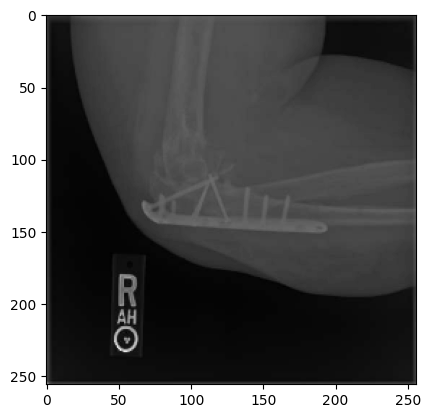

In [10]:
random_training_image = training_images[0]
plt.imshow(random_training_image, cmap='gray')
plt.show()

In [11]:
def create_model(input_shape):

    #create a Sequential  model
    model = Sequential()

    #Add the layers
    model.add(Input(input_shape))
    model.add(Rescaling(1.0 / 255))
    #Add 2 convolutional layers paired with max pooling layers
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
   
    #Flatten the output so that it can be processed as a Vector by the subsequnet Dense layer
    model.add(Flatten())

    #add a fully connected layer with  64 neurons and a relu activation function ouput shape = 64
    model.add(Dense(64, kernel_regularizer=REGULARIZER, activation='relu'))
    #add output layer with a single neuron and a sigmoind activation to represent the binary classification
    model.add(Dense(1, activation='sigmoid'))

    return model

In [12]:
def train_model(X_train, y_train, X_valid, y_valid):
    
    callbacks = [EarlyStopping(patience=3, restore_best_weights=True)]
    model = create_model(INPUT_SHAPE)
    model.compile(optimizer=OPTIMIZER(),
              loss=LOSS_FUNCTION(),
              metrics=METRICS)
    model_history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), callbacks=callbacks, verbose=VERBOSE)
    clear_session()

    return (model, model_history)

In [13]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)
folds.get_n_splits(training_images)
model_histories = []
validation_scores = []
for fold_index, (train_index, valid_index) in enumerate(folds.split(training_images)):
    X_train, X_valid = training_images[train_index], training_images[valid_index]
    y_train, y_valid = training_labels[train_index], training_labels[valid_index]
    print('Training model for fold:', fold_index + 1)
    model, model_history = train_model(X_train, y_train, X_valid, y_valid)
    model_histories.append(model_history)
    validation_score = model.evaluate(X_valid, y_valid)
    validation_scores.append(validation_score)

[print('validation_score for fold number ', str(index+1), ':' , str(validation_score)) for index, validation_score in enumerate(validation_scores)]

Training model for fold: 1
Epoch 1/25
100/100 - 149s - 1s/step - accuracy: 0.5212 - loss: 1.0464 - val_accuracy: 0.4925 - val_loss: 0.7397
Epoch 2/25
100/100 - 145s - 1s/step - accuracy: 0.5121 - loss: 0.7056 - val_accuracy: 0.5000 - val_loss: 0.7067
Epoch 3/25
100/100 - 145s - 1s/step - accuracy: 0.5322 - loss: 0.7199 - val_accuracy: 0.5565 - val_loss: 0.7257
Epoch 4/25
100/100 - 142s - 1s/step - accuracy: 0.5555 - loss: 0.7253 - val_accuracy: 0.5465 - val_loss: 0.7240
Epoch 5/25
100/100 - 142s - 1s/step - accuracy: 0.5489 - loss: 0.7248 - val_accuracy: 0.5704 - val_loss: 0.7211
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.4956 - loss: 0.7077
Training model for fold: 2
Epoch 1/25
100/100 - 145s - 1s/step - accuracy: 0.4969 - loss: 0.9298 - val_accuracy: 0.5013 - val_loss: 0.6995
Epoch 2/25
100/100 - 143s - 1s/step - accuracy: 0.5080 - loss: 0.6968 - val_accuracy: 0.5214 - val_loss: 0.6959
Epoch 3/25
100/100 - 143s - 1s/step - accuracy: 0.5275 - loss: 0.7000 - val_accuracy: 0

[None, None, None, None, None]

In [14]:
model_histories[3].history

{'accuracy': [0.5209851861000061,
  0.5281181335449219,
  0.5274897813796997,
  0.5378573536872864,
  0.5243480801582336],
 'loss': [0.9351863265037537,
  0.7010990977287292,
  0.696169376373291,
  0.7023944854736328,
  0.7251945734024048],
 'val_accuracy': [0.5603014826774597,
  0.5037688612937927,
  0.4987437129020691,
  0.552763819694519,
  0.5301507711410522],
 'val_loss': [0.6978934407234192,
  0.6962066888809204,
  0.6973928213119507,
  0.7026577591896057,
  0.7107102870941162]}

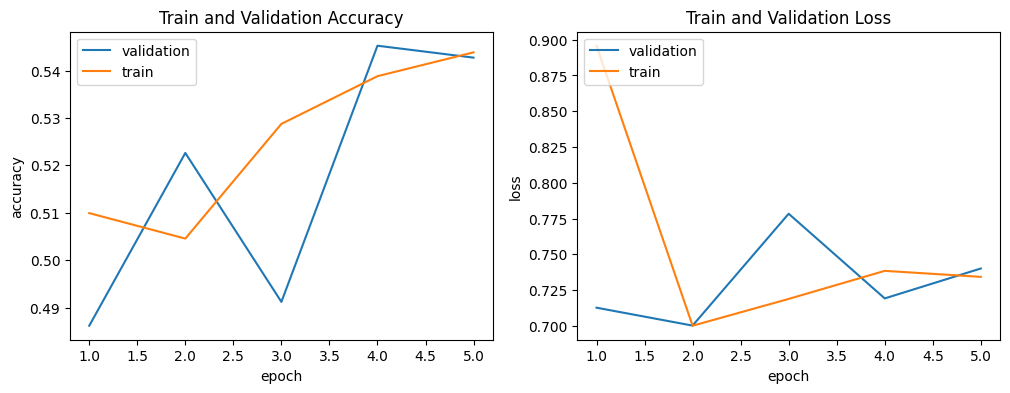

In [15]:
#plot the best model
model_history = model_histories[2]
epochs = len(model_history.history['accuracy'])
train_accuracy = model_history.history['accuracy']
valid_accuracy = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
valid_loss = model_history.history['val_loss']

fig, (accuracy, loss) = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(12,4 )
accuracy.plot(range(1, epochs+1), valid_accuracy) 
accuracy.plot(range(1, epochs+1), train_accuracy)  
accuracy.set_ylabel('accuracy')
accuracy.set_xlabel('epoch')
accuracy.legend(['validation','train'], loc='upper left')
accuracy.set_title('Train and Validation Accuracy')

loss.plot(range(1, epochs+1), valid_loss)
loss.plot(range(1, epochs+1), train_loss)
loss.set_ylabel('loss')
loss.set_xlabel('epoch')
loss.legend(['validation', 'train'], loc='upper left')
loss.set_title('Train and Validation Loss')

plt.show()

In [16]:
def plot_training_history(model_histories):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    for model_history in model_histories:
        ax[0].plot(model_history.history['loss'], label='training loss')
        ax[0].plot(model_history.history['val_loss'], label='validation loss')
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        ax[1].plot(model_history.history['accuracy'], label='training accuracy')
        ax[1].plot(model_history.history['val_accuracy'], label='validation accuracy')
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
    plt.show()

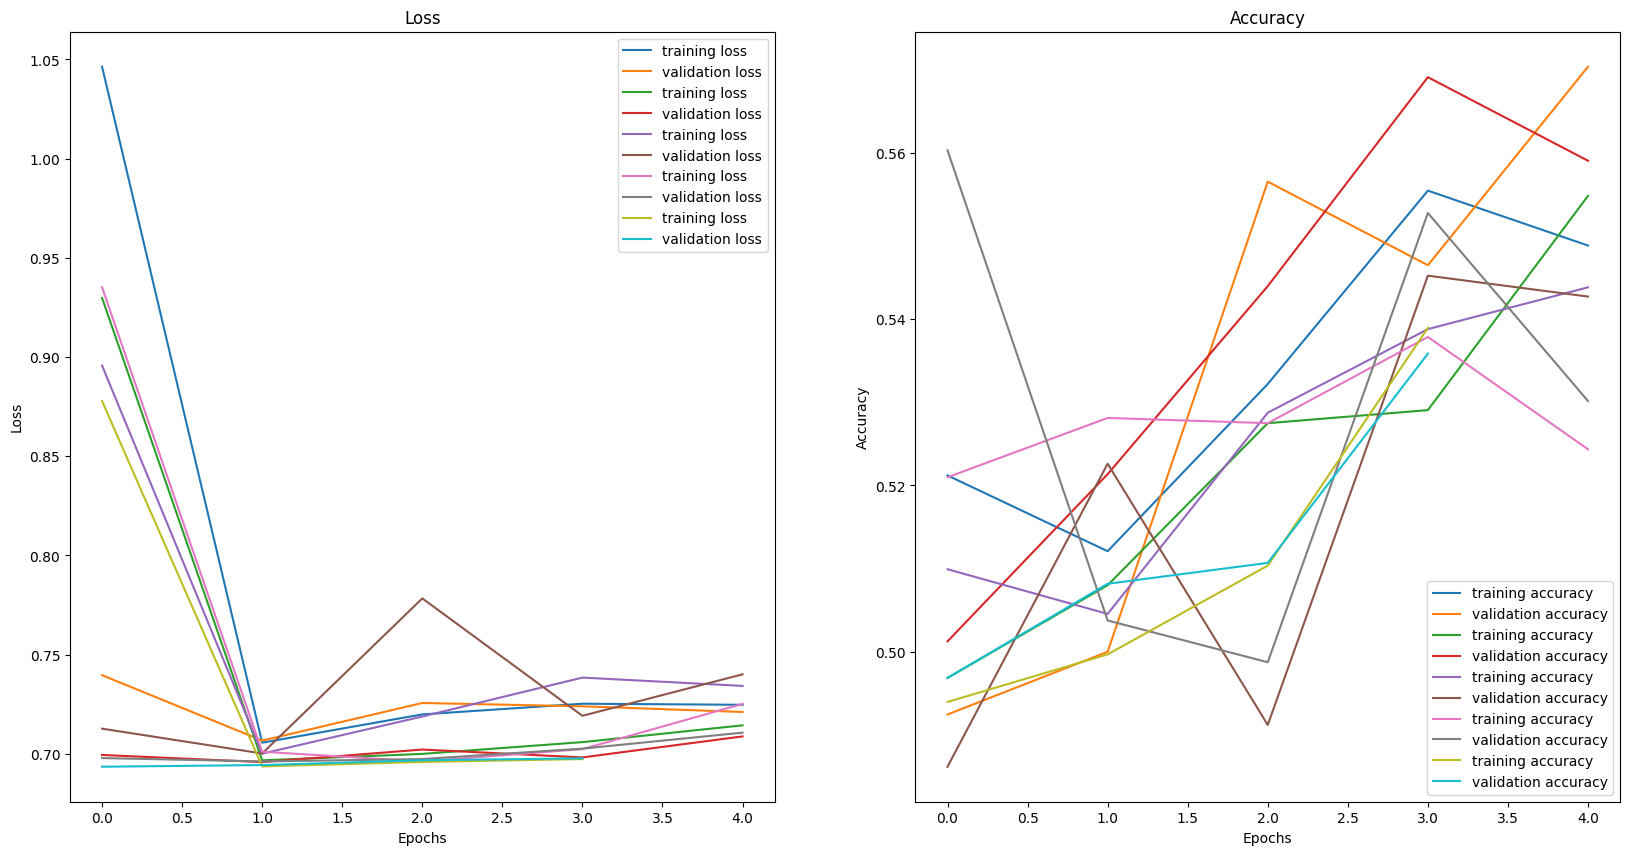

In [17]:
plot_training_history(model_histories)